# Scowl Simulated Deployment

The objective of this notebook is to:
1. Define the goals of the simulation run
2. Declare the methods of running the simulation
3. Visualize the simulation parameters
4. Run the simulations
5. Process the log data
6. Visualize the results

## What is the scope of the simulation?

1. Confirm the simulation parameters
    1. `Peer` mix (generator, consumer, superpeer/storage)
    2. Supply/Demand ratio
    3. `Peer` to `Tracker` network latency
    
2. The evaluation should answer:
    1. How many peers were rebalanced (independant variable) and how fast was the tracker able to rebalance its peers (dependant variable – in Hz)?
    2. What was the limiting resource? (e.g., network, cpu, memory, etc.)
    3. At what scale of peers did the limiting factor occur?
    4. How long was the average peer "starved" for electricity?
    5. When demand exceeded supply, did a black out occur?
    6. When should the system be sharded?
    7. When the network partitioned, did peers operating in SOC mode cause a black out in their region?
    8. *Stretch Goal* How small of a partition can the grid operate under?

# Simulation "Run Sheet"

The simulation should have (2) main parts:
1. **Electrical stress test under a healthy network** – There are imbalances between supply and demand, but the network remains up. `Trackers` attempt to pair `Consumers` with `Generators` that have additional capacity, the goal is to re-build the *ephemeral distribution trees* as fast as possible, so that `Consumer` starvation is minimized.
2. **Electrical stress test under a partitioned network** – Communication between the tracker and the peers is broken. Each `Consumer` is operating as a self optimizing consumer (soc). Each `Generator` is a self-optimizing generator (sog). `Generators` can **only** warn SOCs of an impending black out by sending a `capacity_low` rpc to their partition. This is analagous to real-world electricity consumers feeling the voltage sag of a brown-out, in advance of a black out. The warned consumers respond by self-imposing a call to `DemandResponse()`, until the `Generator` unchokes them <sup>1</sup>. The key metric here is how many `capacity_low` messages are sent, and how much *deferred consumption* consumers experience (i.e., this messaged in time and kWhs).

The energy mix will be based on the current the energy mix of New York State, and renewables will experience the same fluctations. The same "day" will be simulated for both the healthy network day (scowl) and the partitioned network day (soc/sog).

***
<sup>1</sup> This behaviour mimics the TCP congestion control algorithm, with a similar expectation that backing off demand will result in data (electricity) flowing again.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Electricity Generation Mix NY State (2020)

In [669]:
g22 = pd.read_csv("data/2022_elec_gen_mix.csv")
g22.set_index("type", inplace= True)
g22['portion'] = g22.mwh / (g22.mwh.sum())
g22.sort_values('mwh', ascending=False, inplace=True)
g22['renewable'] = [False, False, True, True, True, False, True, True]
g22

,mwh,portion,renewable
type,,,
natural gas-fired,7530000,0.585810,False
nuclear,2380000,0.185156,False
hydroelectric,2234000,0.173798,True
land-based wind,383000,0.029796,True
utility-scale solar,287000,0.022328,True
petroleum-fired,40000,0.003112,False
offshore wind,0,0.000000,True
distributed solar,0,0.000000,True


In [670]:
# pd.concat([g22,pd.DataFrame(g22.sum()).T]).rename(index={0: '2022 Total'})

In [671]:
# Assigning consistent colors for graphs
import matplotlib.colors as mcolors
mcolors.TABLEAU_COLORS

colors = []
for i, v in enumerate(g22.index):
    colors.append([v, list(mcolors.TABLEAU_COLORS.items())[i][0]])
colors = pd.DataFrame(colors, columns=["type", "color"]).set_index("type")

# using either is fine
g22 = pd.concat([g22,colors], axis = 1)
color_dict = g22.color.to_dict()

***

## Electricity Generation Mix NY State (2030)

In [672]:
g30 = pd.read_csv("data/2030_elec_gen_mix.csv")
g30.set_index("type", inplace= True)
g30['portion'] = g30.mwh / (g30.mwh.sum())
g30.sort_values('mwh', ascending=False, inplace=True)
g22 = g22.reindex(g30.index.to_list()) # make g22 use same index order as g30
g30['renewable'] = g22['renewable']
g30['color'] = g22['color']
g30
# pd.concat([g30,pd.DataFrame(g30.sum()).T]).rename(index={0: '2023 Total'})

,mwh,portion,renewable,color
type,,,,
hydroelectric,3252480,0.302400,True,tab:green
nuclear,2380000,0.221281,False,tab:orange
natural gas-fired,1276889,0.118719,False,tab:blue
offshore wind,1258400,0.117000,True,tab:pink
utility-scale solar,1132560,0.105300,True,tab:purple
distributed solar,761493,0.070800,True,tab:gray
land-based wind,693733,0.064500,True,tab:red
petroleum-fired,0,0.000000,False,tab:brown


## Electricity Mix 2022 and 2030

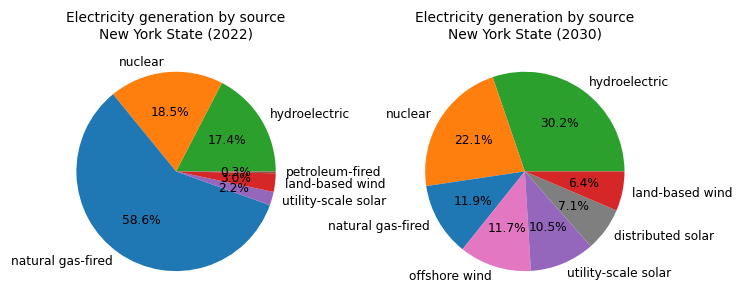

In [677]:
fig = plt.figure(figsize=(7.5,3), dpi=110)

ax1 = fig.add_subplot(121)
ax1.pie(np.round(g22[g22.portion > 0].portion*100,1), labels=g22[g22.portion > 0].index,autopct='%.1f%%', textprops={'fontsize': 8}, colors=g22[g22.portion > 0].color)
ax1.title.set_text('Electricity generation by source\nNew York State (2022)')
ax1.title.set_size(9)

ax2 = fig.add_subplot(122)
ax2.pie(np.round(g30[g30.portion > 0].portion*100,1), labels=g30[g30.portion > 0].index,autopct='%.1f%%', textprops={'fontsize': 8}, colors=g30[g30.portion > 0].color)
ax2.title.set_text('Electricity generation by source\nNew York State (2030)')
ax2.title.set_size(9)

plt.show()

## Electricity Generation by Month

In [8]:
monthly_elec = pd.read_csv("data/ny_electricity_by_month.csv", skiprows=4)
monthly_elec.drop(["units","source key"], axis=1,inplace=True)
monthly_elec.set_index("description", inplace=True)
monthly_elec = monthly_elec.T
monthly_elec.drop(["New York", "New York : all fuels (utility-scale)"], axis=1,inplace=True)
monthly_elec.columns = ["hydroelectric", "other_renewables"]

month_years = [i.split("-") for i in monthly_elec.index.to_list()]
months = [i[0] for i in month_years]
years = [int(i[1]) for i in month_years]

monthly_elec.index = months
monthly_elec['year'] = np.array(years) + 2000

monthly_elec.head(12)

,hydroelectric,other_renewables,year
Jan,2017.0,154.0,2001
Feb,2013.0,141.0,2001
Mar,2203.0,156.0,2001
Apr,2043.0,141.0,2001
May,2053.0,159.0,2001
Jun,1921.0,154.0,2001
Jul,1801.0,153.0,2001
Aug,1698.0,159.0,2001
Sep,1575.0,147.0,2001
Oct,1740.0,138.0,2001


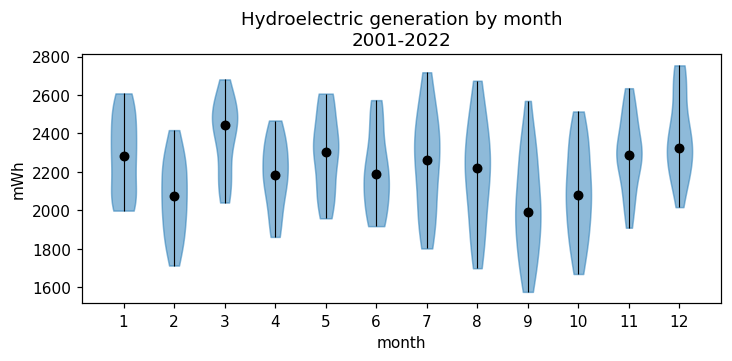

In [177]:
hydro_mwh = []
for month in monthly_elec.index.unique():
    hydro_mwh.append(monthly_elec.hydroelectric[monthly_elec.index == month].values)

hydro_mins = pd.DataFrame(hydro_mwh).T.min()
hydro_maxs = pd.DataFrame(hydro_mwh).T.max()
hydro_meds = pd.DataFrame(hydro_mwh).T.median()

fig, ax1 = plt.subplots(figsize=(7.5,3), dpi=110)

parts1 = ax1.violinplot(hydro_mwh, showmedians=False, showextrema=False)
ax1.set_title('Hydroelectric generation by month\n2001-2022')
ax1.set_xticks(np.arange(1, len(months) + 1))
ax1.set_ylabel("mWh")
ax1.set_xlabel("month")

for pc in parts1['bodies']:
    pc.set_ec('tab:blue')
    pc.set_facecolor('tab:blue')
    pc.set_alpha(0.5)
    
# ax1.scatter([1]*len(months), monthly_elec.hydroelectric, marker='o', color='k', s=15, alpha=.1,zorder=3)
ax1.scatter(range(1,len(months)+1), hydro_meds, marker='o', color='k', s=30, alpha=1,zorder=3)
ax1.vlines(range(1,len(months)+1), hydro_mins, hydro_maxs, color='k', linestyle='-', lw=0.75)

plt.show()

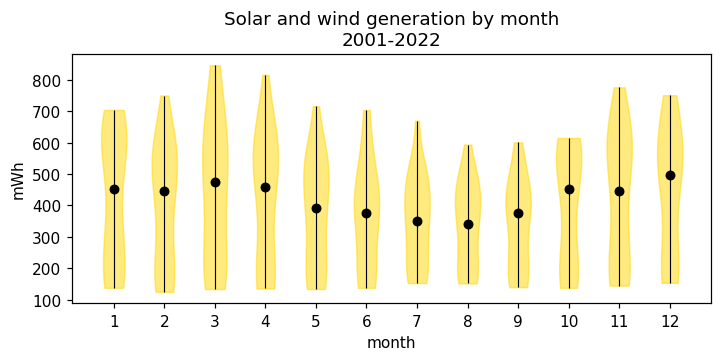

In [179]:
other_mwh = []
for month in monthly_elec.index.unique():
    other_mwh.append(monthly_elec.other_renewables[monthly_elec.index == month].values)

other_mins = pd.DataFrame(other_mwh).T.min()
other_maxs = pd.DataFrame(other_mwh).T.max()
other_meds = pd.DataFrame(other_mwh).T.median()

fig, ax1 = plt.subplots(figsize=(7.5,3), dpi=110)

parts1 = ax1.violinplot(other_mwh, showmedians=False, showextrema=False)
ax1.set_title('Solar and wind generation by month\n2001-2022')
ax1.set_xticks(np.arange(1, len(months) + 1))
ax1.set_ylabel("mWh")
ax1.set_xlabel("month")

for pc in parts1['bodies']:
    pc.set_ec('gold')
    pc.set_facecolor('gold')
    pc.set_alpha(0.5)
    
# ax1.scatter([1]*len(months), monthly_elec.hydroelectric, marker='o', color='k', s=15, alpha=.1,zorder=3)
ax1.scatter(range(1,len(months)+1), other_meds, marker='o', color='k', s=30, alpha=1,zorder=3)
ax1.vlines(range(1,len(months)+1), other_mins, other_maxs, color='k', linestyle='-', lw=0.75)

plt.show()

***

## Understanding DERs in 2022

In [224]:
cols = [
    'Number of Devices',
    'Rated Electric Generation Per Device (kW)',
    'Primary Fuel',
    'ESS Type',
    'ESS Subtype',
    'Rated Electric Storage Capacity Per Device (kWh)',
    'Equivalent Electrical Storage Capacity Per Device from Cooling Sources (kWh)',
]

short_cols = [
    'quantity',
    'generation',
    'fuel',
    'storage_type',
    'storage_subtype',
    'storage_capacity',
    'cooling_storage_capacity',
]

ders = pd.read_excel('data/nys_der_metrics.xlsx', sheet_name='DE Resources')
ders = ders[cols]
ders.columns = short_cols
ders.head()

,quantity,generation,fuel,storage_type,storage_subtype,storage_capacity,cooling_storage_capacity
0,1,318.99,Solar,NaN,NaN,NaN,NaN
1,2,75.00,Natural Gas,NaN,NaN,NaN,NaN
2,1,65.00,Natural Gas,NaN,NaN,NaN,NaN
3,1,2507.67,Solar,NaN,NaN,NaN,NaN
4,1,2152.08,Solar,NaN,NaN,NaN,NaN


In [225]:
total_gen = ders.generation.sum()
total_electric_storage = ders.storage_capacity.sum()
total_cooling_storage = ders.storage_capacity.sum()

### DER Growth Assumptions 

Per state motor vehicle registrations in 2017, there **4%** of all cars in the US are registered in NYS.

[EEI](https://www.eei.org/News/news/All/eei-projects-26-million-electric-vehicles-will-be-on-us-roads-in-2030#:~:text=The%20number%20of%20EVs%20on,on%20U.S.%20roads%20in%202030.) projects that there will be 26.4M electric cars on the road, meaning 4% of those will be in NYS.

Per [Car and Driver](https://www.caranddriver.com/features/g36278968/best-selling-evs-of-2021/) the number one selling electric car in 2021 was the Tesla Model Y with a battery size of ~80kWhs [source](https://www.caranddriver.com/tesla/model-y/specs).

So let's assume that there's a total of 1056000 electric vehicles (26.4M vehicles * 4% in NYS) with a total storage capacity of 84,480,000 kWhs or 84,480 MWhs of ***additional*** electric storage capacity will be available in 2030.

Let's double the adoption of cooling storage...

In [295]:
# All in MWh
der_stats = [
        {'year': 2022, 'elec_gen': total_gen/1000, 'elec_storage': total_electric_storage/1000, 'cooling_storage': total_electric_storage/1000},
        {'year': 2030, 'elec_gen': total_gen*2.5/1000, 'elec_storage': (total_electric_storage/1000) + 84480, 'cooling_storage': total_electric_storage*2/1000}
    ]

print("DER Capacities by type")
der_stats = pd.DataFrame(der_stats)
der_stats.set_index("year", inplace=True)
der_stats

DER Capacities by type


,elec_gen,elec_storage,cooling_storage
year,,,
2022,2200.199577,358.442,358.442
2030,5500.498943,84838.442,716.884


Operational DER Resources (2022)

Total electric generation (MW): 2200.199577
Total electric storage (MWh):    358.442
Total cooling storage (MWh):     358.442


Estimated DER Resources (2030)

Total electric generation (MW): 5500.4989425
Total electric storage (MWh):   84838.442
Total cooling storage (MWh):     716.884


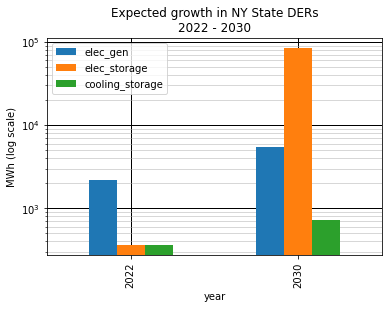

In [350]:
print("Operational DER Resources (2022)\n")
print("Total electric generation (MW): {}".format(total_gen/1000))
print("Total electric storage (MWh):    {}".format(total_electric_storage/1000))
print("Total cooling storage (MWh):     {}".format(total_electric_storage/1000))

print("\n\nEstimated DER Resources (2030)\n")
print("Total electric generation (MW): {}".format(total_gen*2.5/1000))
print("Total electric storage (MWh):   {}".format((total_electric_storage/1000) + 84480))
print("Total cooling storage (MWh):     {}".format(total_electric_storage*2/1000))

der_stats.plot.bar(zorder=5)
plt.yscale('log') # or "log"
plt.ylabel("MWh (log scale)")
plt.grid(which='major', zorder=3, color='k', linewidth=1) # color='r', linestyle='-', linewidth=2
plt.grid(which='minor', zorder=4, linewidth=0.5)
plt.title("Expected growth in NY State DERs\n2022 - 2030")
plt.show()

## Simulating a dymanic electricity market

To raise the stakes that **ScOWL** must content with, we'll have an aggregate supply that is always chasing the demand curve. In order to prevent blackouts, and minimize brownouts, we'll have to rapidly recalcuate the *ephermal distribution trees* for each `Generateor` presently available.

#### In short,

- When we have an excess of supply, our storage resources should kick in.
- When we have an too much demand, a `Generator` should signal to each `Consumer` in their distribution tree to reduce demand (via a `low_capacity` RPC).
- If a `Consumer` does not back off fast enough, it could blackout their whole tree.
- When a `Consumers` region is blackedout, the `Tracker` tries to pair its consumption with another `Generator` and add it to their tree. If it cannot find a `Generator` with available capacity. That `Consumer` gets ***starved***. 
- `Consumer` starvation is a key metric for evaluation.

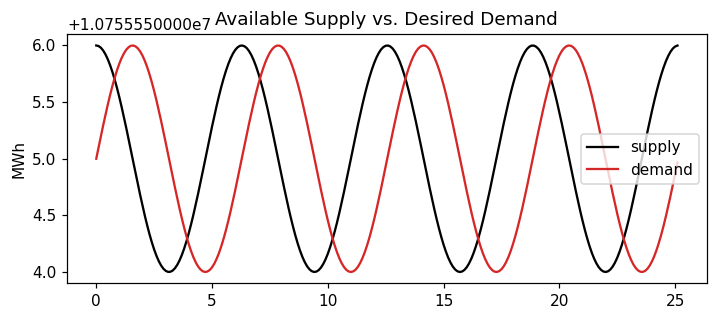

In [353]:
time = np.arange(0,8*np.pi,0.1)
supply = np.cos(time) + g30.mwh.sum()
demand = np.sin(time) + g30.mwh.sum()
data = {
    "supply": supply,
    "demand": demand
}
df = pd.DataFrame(data, index=time)

fig, ax1 = plt.subplots(figsize=(7.5,3), dpi=110)

ax1.plot(df['supply'], color="black")
ax1.plot(df['demand'], color="tab:red")            
ax1.set_ylabel("MWh")
ax1.set_title("Available Supply vs. Desired Demand")
plt.legend(["supply","demand"])

plt.show()

## How many generators are online today?

State codes:

|state|code|
|---|---|
|NY | 36|
|PA | 42|
|MA | 25|
|NJ | 34|

In [426]:
gen_facilities = pd.read_csv('data/2021_generation_facilities.csv',skiprows=1)
gen_facilities.head(3)

,"Owner, Operator, and/or Billing Organization",station unit,zone,PTID,town,county,st,In-Service Date,Name Plate Rating (V) MW,cris_summer,cris_winter,cap_summer,cap_winter,D U A L,Unit Type,Type 1,Type 2,gwh,Notes
0,Arkwright Summit Wind Farm,Arkwright Summit Wind Farm,A,323751,Arkwright,13,36,9/1/18,78.4,78.4,78.4,78.4,78.4,NaN,WT,WND,NaN,255.8,NaN
1,"Astoria Energy II, LLC",Astoria Energy 2 - CC3,J,323677,Queens,81,36,7/1/11,330.0,288.0,376.3,285.7,329.5,YES,CC,NG,FO2,2899.9,(G)
2,"Astoria Energy II, LLC",Astoria Energy 2 - CC4,J,323678,Queens,81,36,7/1/11,330.0,288.0,376.3,285.7,329.5,YES,CC,NG,FO2,0.0,NaN


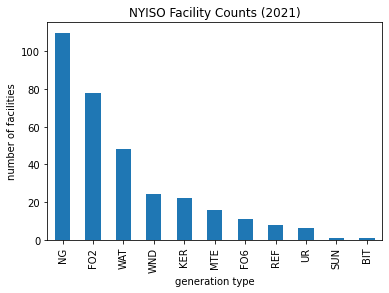

In [435]:
# many hydro facilities produced no electricity in 2021, maybe they are old?
fig = gen_facilities[gen_facilities.gwh > 0]["Type 1"].value_counts().plot.bar()
fig.set_title("NYISO Facility Counts (2021)")
fig.set_ylabel("number of facilities")
fig.set_xlabel("generation type")
plt.show()

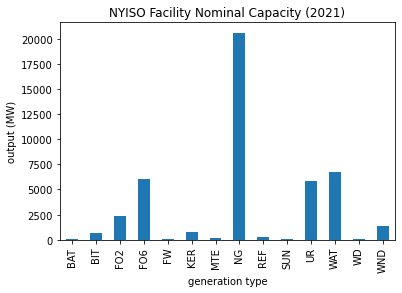

In [445]:
fig = gen_facilities.groupby("Type 1").sum()["Name Plate Rating (V) MW"].plot.bar()
fig.set_title("NYISO Facility Nominal Capacity (2021)")
fig.set_ylabel("output (MW)")
fig.set_xlabel("generation type")
plt.show()

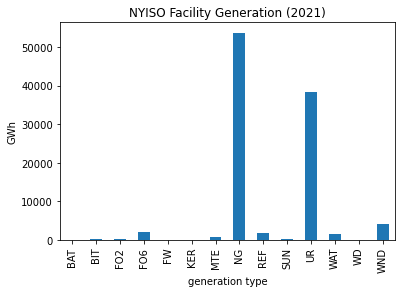

In [444]:
fig = gen_facilities.groupby("Type 1").sum()["gwh"].plot.bar()
fig.set_title("NYISO Facility Generation (2021)")
fig.set_ylabel("GWh")
fig.set_xlabel("generation type")
plt.show()

### Average output by facility type

In [475]:
num_facilities = gen_facilities[gen_facilities.gwh > 0]["Type 1"].value_counts()
nominal_capacity = gen_facilities.groupby("Type 1").sum()["Name Plate Rating (V) MW"]
avg_facility_cap = nominal_capacity / num_facilities
avg_facility_cap = np.round(avg_facility_cap[avg_facility_cap > 0]).astype(int)
avg_facility_cap

BIT    655
FO2     30
FO6    547
KER     34
MTE      8
NG     188
REF     30
SUN     56
UR     975
WAT    140
WND     57
dtype: int64

***

# Testbed Parameters

## Part 1: Instantiating peers

### Generators

Drawing from the stats above, we will instate generators proportional to:
1. Total generation capacity
2. Generation capacity by unit type
3. Number of units as function of average unit size

Per the 2021 "Gold Book" the forecasted total capacity is expected to be: **41,071 MW**

Per the 2021 "Gold Book" the forecasted Summer Peak Demand to be: **32,121 MW**

Per the 2021 "Gold Book" the forecasted Winter Peak Demand to be: **25,275 MW**


In [564]:
# total capacity (MW)
nominal_cap = 41071
# Summer peak demand (MW)
summer_peak = 32121
# Winter peak demand (MW)
winter_peak = 25275

In [565]:
std_index_counts = {
    "hydroelectric": ["WAT"],
    "nuclear": ["UR"],
    "natural gas-fired": ["NG","MTE"],
    "utility-scale solar": ["SUN"],
    "land-based wind": ["WND"],
    "petroleum-fired": ["BIT","KER","FO2","FO6","REF"]
}

In [753]:
# # uncomment to view exact number of facilities, by sub-type
# gen_facilities[gen_facilities.gwh > 0]["Type 1"].value_counts()

In [757]:
def sumAndReindex(data, indexes):
    reformatted_data = []
    for t in indexes:
        reformatted_data.append([t, data[indexes[t]].sum()]) 
    return reformatted_data

facil_counts = sumAndReindex(gen_facilities[gen_facilities.gwh > 0]["Type 1"].value_counts(), std_index_counts)
facil_counts = pd.DataFrame(facil_counts, columns=["type","counts"]).set_index("type")
print("True Count of Generation Facilities by Type")
facil_counts

True Count of Generation Facilities by Type


,counts
type,
hydroelectric,48
nuclear,6
natural gas-fired,126
utility-scale solar,1
land-based wind,24
petroleum-fired,120


In [745]:
def avgAndReindex(data, indexes):
    reformatted_data = []
    for t in indexes:
        reformatted_data.append([t, data[indexes[t]].mean()]) 
    return reformatted_data

avg_gen = avgAndReindex(avg_facility_cap, std_index_counts)
avg_gen = pd.DataFrame(avg_gen, columns=["type","capacity_mw"]).set_index("type")
print("Average Nominal Generation Facility Capacity (MW)")
avg_gen

Average Nominal Generation Facility Capacity (MW)


,capacity_mw
type,
hydroelectric,140.0
nuclear,975.0
natural gas-fired,98.0
utility-scale solar,56.0
land-based wind,57.0
petroleum-fired,259.2


## Compute number of generation facilities to instantiate 

\<facility_type\><sub>total</sub> = total_generation<sub>nominal</sub> / generation_per_facility<sub>average</sub>

In [727]:
# add better notes HERE for parametric facilities counts
facil_counts = np.round((nominal_cap * g22.portion / avg_gen.T))
facil_counts = facil_counts.T.sort_values('counts', ascending=False)
facil_counts

,counts
type,
natural gas-fired,246.0
hydroelectric,51.0
land-based wind,21.0
utility-scale solar,16.0
nuclear,8.0
petroleum-fired,0.0
distributed solar,NaN
offshore wind,NaN


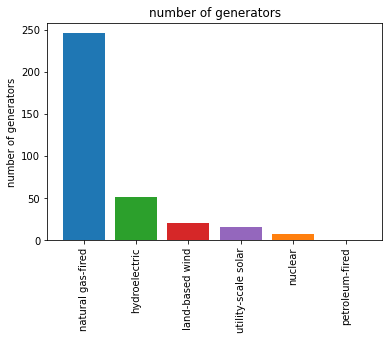

In [752]:
plt.bar(facil_counts.index, facil_counts.counts.values, color=colors.color[facil_counts.index].values)
plt.ylabel("number of generators")
plt.xticks(rotation=90)
# plt.title("number of generators")
plt.show()

In [761]:
final_gen_stats = pd.concat([facil_counts, avg_gen], axis=1)
final_gen_stats

,counts,capacity_mw
type,,
hydroelectric,48,140.0
nuclear,6,975.0
natural gas-fired,126,98.0
utility-scale solar,1,56.0
land-based wind,24,57.0
petroleum-fired,120,259.2


***

### Consumers

The most recently published dataset is from 2018. We'll base our portion of consumers based on that.

In [804]:
elec_customers = pd.read_csv('data/electricity_sales_by_customer_GWh.csv').set_index("Year").drop("Grand Total", axis=1)
portion_elec_customers = elec_customers.loc[2018] / elec_customers.loc[2018].sum() 

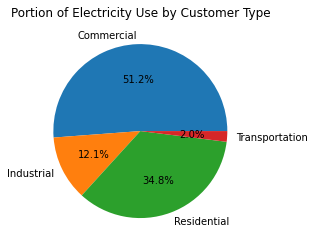

In [805]:
plt.pie(portion_elec_customers, labels=portion_elec_customers.index, autopct='%.1f%%')
plt.title("Portion of Electricity Use by Customer Type")
plt.show()

According to [Census.gov](https://www.census.gov/quickfacts/NY), there are **8,531,063 housing units** in New York State, as of 2021.

According to the [NYSERDA commercial baseline study](https://www.nyserda.ny.gov/about/publications/building-stock-and-potential-studies/commercial-statewide-baseline-study), there are **367,223 commercial buildings** in New York State. (Vol 1., pg.13)

For simplicity, we'll assume that **transportation** and **industrial** end uses have ***fixed*** energy consumption.

In [795]:
res_units = 8531063 
com_units = 367223

In [802]:
summer_peak

32121

In [808]:
# Average consumption by unit type (MW)
consump_by_cust_type = summer_peak * portion_elec_customers
consump_by_cust_type

Commercial        16441.956826
Industrial         3872.841925
Residential       11173.332131
Transportation      632.869118
Name: 2018, dtype: float64

In [821]:
res_unit_consump = consump_by_cust_type["Residential"] / res_units
com_unit_consump = consump_by_cust_type["Commercial"] / com_units
print("Residential Units:          {}".format(res_units))
print("Avg. res unit consumption:  {} MW".format(np.round(res_unit_consump, 5)))
print("Commercial Units:           {}".format(com_units))
print("Avg. com. unit consumption: {} MW".format(np.round(com_unit_consump, 5)))

Residential Units:          8531063
Avg. res unit consumption:  0.00131 MW
Commercial Units:           367223
Avg. com. unit consumption: 0.04477 MW


***

In [ ]:
# plt.pie(np.round(g30[g30.portion > 0].portion*100,1), labels=g30[g30.portion > 0].index,autopct='%.1f%%')
# plt.title("Electricity generation by source\nNew York State (2030)")
# plt.show()

In [ ]:
# plt.pie(np.round(g22[g22.portion > 0].portion*100,1), labels=g22[g22.portion > 0].index,autopct='%.1f%%')
# plt.title("Electricity generation by source\nNew York State (2022)")
# plt.show()

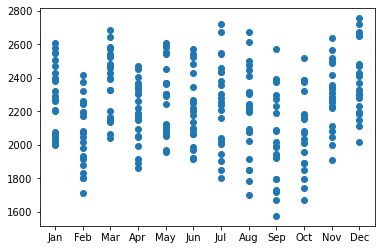

In [9]:
# Monthly electric generation Hydro
plt.scatter(monthly_elec.index, monthly_elec.hydroelectric)
plt.show()

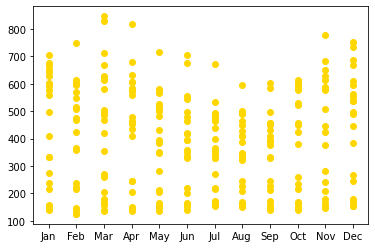

In [10]:
# Monthly electric generation Solar and Wind
plt.scatter(monthly_elec.index, monthly_elec.other_renewables, color="gold")
plt.show()